In [224]:
%%capture
!pip install transformers datasets prettytable

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset
from prettytable import PrettyTable

from tqdm import tqdm
from transformers import BertTokenizer

import matplotlib.pyplot as plt

plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('lines', markersize=10)

In [3]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/Users/quyenlinhta/PycharmProjects/llm-iasd/llm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
def preprocessing_fn(data, tokenizer):
    tokenized_output = tokenizer(
        data["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False
    )
    data["review_ids"] = tokenized_output["input_ids"]
    data["label"] = [0 if sentiment == "negative" else 1 for sentiment in data["sentiment"]]
    return data

In [6]:
n_samples = 20000
dataset = dataset.shuffle(seed=42)
dataset = dataset.select(range(n_samples))
tokenized_dataset = dataset.map(lambda x: preprocessing_fn(x, tokenizer), batched=True)
tokenized_dataset.set_format(type='torch', columns=['review_ids', 'label'])
document_train_set, document_valid_set = tokenized_dataset.train_test_split(test_size=0.2).values()

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [7]:
table = PrettyTable()
table.field_names = ["Dataset", "Size", "Number of classes"]
table.add_row(["Train", len(document_train_set), len(document_train_set.unique("label"))])
table.add_row(["Validation", len(document_valid_set), len(document_valid_set.unique("label"))])
print(table)

Flattening the indices:   0%|          | 0/16000 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/4000 [00:00<?, ? examples/s]

+------------+-------+-------------------+
|  Dataset   |  Size | Number of classes |
+------------+-------+-------------------+
|   Train    | 16000 |         2         |
| Validation |  4000 |         2         |
+------------+-------+-------------------+


In [8]:
print(document_train_set.column_names)

['review', 'sentiment', 'review_ids', 'label']


In [9]:
def extract_words_contexts(document_ids, radius):
    if len(document_ids) == 0:
        return torch.empty(0), torch.empty(0, 2 * radius)
    if not isinstance(document_ids, torch.Tensor):
        document_ids = torch.tensor(document_ids)
    padding_token = -1
    padded_document_ids = torch.cat([torch.full((radius,), padding_token), document_ids, torch.full((radius,), padding_token)])
    contexts = [
        torch.cat([
            padded_document_ids[i:i+radius],
            padded_document_ids[i+radius+1:i+2*radius+1]
        ])
        for i in range(radius, len(document_ids) + radius)
    ]
    contexts = torch.stack([c if len(c) == 2 * radius else torch.cat([c, torch.full((2 * radius - len(c),), padding_token)]) for c in contexts])
    return document_ids, contexts

def flatten_dataset_to_list(dataset, radius):
    aggregated_word_ids, aggregated_contexts, aggregated_labels = [], [], []
    for document in dataset:
        word_ids, contexts = extract_words_contexts(document['review_ids'], radius)
        aggregated_word_ids.extend(word_ids.tolist())
        aggregated_contexts.extend(contexts.tolist())
        aggregated_labels.extend([document['label']] * len(word_ids))
    return aggregated_word_ids, aggregated_contexts, aggregated_labels

In [10]:
radius = 5
train_word_ids, train_contexts, train_labels = flatten_dataset_to_list(document_train_set, radius)
valid_word_ids, valid_contexts, valid_labels = flatten_dataset_to_list(document_valid_set, radius)

table = PrettyTable()
table.field_names = ["IDs", "Contexts", "Labels"]
table.add_row([len(train_word_ids), len(train_contexts), len(train_labels)])
table.add_row([len(valid_word_ids), len(valid_contexts), len(valid_labels)])
print(table)

+---------+----------+---------+
|   IDs   | Contexts |  Labels |
+---------+----------+---------+
| 3289299 | 3289299  | 3289299 |
|  823510 |  823510  |  823510 |
+---------+----------+---------+


In [11]:
class WordContextDataset(torch.utils.data.Dataset):
    def __init__(self, word_ids, contexts, labels):
        assert len(word_ids) == len(contexts) == len(labels), "Length of word_ids, contexts, and labels must be the same"
        self.word_ids = torch.tensor(word_ids, dtype=torch.long)
        self.contexts = torch.tensor(contexts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.word_ids)

    def __getitem__(self, idx):
        return {
            'word_id': self.word_ids[idx],
            'context': self.contexts[idx],
            'label': self.labels[idx]
        }

In [12]:
train_set = WordContextDataset(train_word_ids, train_contexts, train_labels)
valid_set = WordContextDataset(valid_word_ids, valid_contexts, valid_labels)

In [13]:
table = PrettyTable()
table.field_names = ["Dataset", "Size", "Number of classes"]
table.add_row(["Train", len(train_set), torch.unique(train_set.labels).shape[0]])
table.add_row(["Validation", len(valid_set), torch.unique(valid_set.labels).shape[0]])
print(table)

+------------+---------+-------------------+
|  Dataset   |   Size  | Number of classes |
+------------+---------+-------------------+
|   Train    | 3289299 |         2         |
| Validation |  823510 |         2         |
+------------+---------+-------------------+


In [14]:
def collate_fn(batch, vocabulary_size, K, R):
    word_ids = torch.stack([item['word_id'] for item in batch])
    contexts = torch.stack([item['context'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])
    negative_contexts = torch.randint(low=0, high=vocabulary_size, size=(len(batch), 2 * K * R))
    return {
        'word_id': word_ids,
        'positive_context_ids': contexts,
        'negative_context_ids': negative_contexts,
        'labels': labels
    }

In [18]:
vocabulary_size = len(tokenizer.get_vocab())
batch_size = 128
K, R = 5, 5

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, vocabulary_size, K, R))
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, collate_fn=lambda x: collate_fn(x, vocabulary_size, K, R))

In [19]:
train_loader.dataset[0], train_loader.dataset[1], train_loader.dataset[2]

({'word_id': tensor(1045),
  'context': tensor([1045, 3866, 2023, 2143, 1012, 9020, 2000, 2191, 1996, 3494]),
  'label': tensor(1)},
 {'word_id': tensor(3866),
  'context': tensor([ 3866,  2023,  2143,  1012,  2009,  2000,  2191,  1996,  3494, 13026]),
  'label': tensor(1)},
 {'word_id': tensor(2023),
  'context': tensor([ 2023,  2143,  1012,  2009,  9020,  2191,  1996,  3494, 13026,  1006]),
  'label': tensor(1)})

In [20]:
table = PrettyTable()
for i, batch in enumerate(train_loader):
    table.field_names = ["Batch", "Word ID", "Positive Contexts", "Negative Contexts", "Labels"]
    table.add_row([i, batch['word_id'].shape, batch['positive_context_ids'].shape, batch['negative_context_ids'].shape, batch['labels'].shape])
    if i == 2:
        break
print(table)

+-------+-------------------+-----------------------+-----------------------+-------------------+
| Batch |      Word ID      |   Positive Contexts   |   Negative Contexts   |       Labels      |
+-------+-------------------+-----------------------+-----------------------+-------------------+
|   0   | torch.Size([128]) | torch.Size([128, 10]) | torch.Size([128, 50]) | torch.Size([128]) |
|   1   | torch.Size([128]) | torch.Size([128, 10]) | torch.Size([128, 50]) | torch.Size([128]) |
|   2   | torch.Size([128]) | torch.Size([128, 10]) | torch.Size([128, 50]) | torch.Size([128]) |
+-------+-------------------+-----------------------+-----------------------+-------------------+


In [21]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, word_ids, context_ids, negative_context_ids):
        target_embeds = self.target_embeddings(word_ids)
        context_embeds = self.context_embeddings(context_ids)
        negative_context_embeds = self.context_embeddings(negative_context_ids)
        positive_dot = torch.bmm(context_embeds, target_embeds.unsqueeze(2)).squeeze(2)
        positive_scores = torch.sigmoid(positive_dot)
        negative_dot = torch.bmm(negative_context_embeds, target_embeds.unsqueeze(2)).squeeze(2)
        negative_scores = torch.sigmoid(negative_dot)
        return positive_scores, negative_scores

    def compute_loss(self, positive_scores, negative_scores):
        positive_labels = torch.ones_like(positive_scores)
        negative_labels = torch.zeros_like(negative_scores)
        positive_loss = F.binary_cross_entropy(positive_scores, positive_labels)
        negative_loss = F.binary_cross_entropy(negative_scores, negative_labels)
        return positive_loss + negative_loss

In [22]:
"""def train_model(model, train_loader, optimizer, epochs, device):
    model.train()
    epoch_losses = []
    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", unit='batch')
        for batch in progress_bar:
            optimizer.zero_grad()
            positive_scores, negative_scores = model(
                batch['word_id'].to(device),
                batch['positive_context_ids'].to(device),
                batch['negative_context_ids'].to(device)
            )
            loss = model.compute_loss(positive_scores, negative_scores)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix(loss="{:.4f}".format(loss.item()))
        epoch_losses.append(total_loss / len(train_loader))
    return epoch_losses"""

'def train_model(model, train_loader, optimizer, epochs, device):\n    model.train()\n    epoch_losses = []\n    for epoch in range(epochs):\n        total_loss = 0\n        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", unit=\'batch\')\n        for batch in progress_bar:\n            optimizer.zero_grad()\n            positive_scores, negative_scores = model(\n                batch[\'word_id\'].to(device),\n                batch[\'positive_context_ids\'].to(device),\n                batch[\'negative_context_ids\'].to(device)\n            )\n            loss = model.compute_loss(positive_scores, negative_scores)\n            loss.backward()\n            optimizer.step()\n            total_loss += loss.item()\n            progress_bar.set_postfix(loss="{:.4f}".format(loss.item()))\n        epoch_losses.append(total_loss / len(train_loader))\n    return epoch_losses'

In [23]:
"""def validate_model(model, valid_loader, device):
    model.eval()
    total_loss = 0
    progress_bar = tqdm(valid_loader, desc="Validation", unit='batch')
    with torch.no_grad():
        for batch in progress_bar:
            positive_scores, negative_scores = model(
                batch['word_id'].to(device),
                batch['positive_context_ids'].to(device),
                batch['negative_context_ids'].to(device)
            )
            loss = model.compute_loss(positive_scores, negative_scores)
            total_loss += loss.item()
            progress_bar.set_postfix(loss="{:.4f}".format(loss.item()))
    average_loss = total_loss / len(valid_loader)
    return average_loss"""

'def validate_model(model, valid_loader, device):\n    model.eval()\n    total_loss = 0\n    progress_bar = tqdm(valid_loader, desc="Validation", unit=\'batch\')\n    with torch.no_grad():\n        for batch in progress_bar:\n            positive_scores, negative_scores = model(\n                batch[\'word_id\'].to(device),\n                batch[\'positive_context_ids\'].to(device),\n                batch[\'negative_context_ids\'].to(device)\n            )\n            loss = model.compute_loss(positive_scores, negative_scores)\n            total_loss += loss.item()\n            progress_bar.set_postfix(loss="{:.4f}".format(loss.item()))\n    average_loss = total_loss / len(valid_loader)\n    return average_loss'

In [24]:
def train_model(model, train_loader, valid_loader, optimizer, epochs, device):
    model.train()
    epoch_losses = []
    epoch_accuracies = []
    validation_losses = []
    validation_accuracies = []
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", unit='batch')
        for batch in progress_bar:
            optimizer.zero_grad()
            positive_scores, negative_scores = model(
                batch['word_id'].to(device),
                batch['positive_context_ids'].to(device),
                batch['negative_context_ids'].to(device)
            )
            loss = model.compute_loss(positive_scores, negative_scores)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            correct_positives = (positive_scores > 0.5).float().sum()
            correct_negatives = (negative_scores < 0.5).float().sum()
            total_correct += correct_positives.item() + correct_negatives.item()
            total_samples += positive_scores.numel() + negative_scores.numel()

            progress_bar.set_postfix(loss="{:.4f}".format(loss.item()))
        progress_bar.close()

        average_train_loss = total_loss / len(train_loader)
        train_accuracy = total_correct / total_samples
        epoch_losses.append(average_train_loss)
        epoch_accuracies.append(train_accuracy)

        validation_loss, validation_accuracy = validate_model(model, valid_loader, device)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        print(f"Epoch {epoch + 1}: Train Loss = {average_train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, Validation Loss = {validation_loss:.4f}, Validation Accuracy = {validation_accuracy:.4f}")

    return epoch_losses, epoch_accuracies, validation_losses, validation_accuracies

def validate_model(model, valid_loader, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    progress_bar = tqdm(valid_loader, desc="Validation", unit='batch')
    with torch.no_grad():
        for batch in progress_bar:
            positive_scores, negative_scores = model(
                batch['word_id'].to(device),
                batch['positive_context_ids'].to(device),
                batch['negative_context_ids'].to(device)
            )
            loss = model.compute_loss(positive_scores, negative_scores)
            total_loss += loss.item()
            correct_positives = (positive_scores > 0.5).float().sum()
            correct_negatives = (negative_scores < 0.5).float().sum()
            total_correct += correct_positives.item() + correct_negatives.item()
            total_samples += positive_scores.numel() + negative_scores.numel()
            progress_bar.set_postfix(loss="{:.4f}".format(loss.item()))
    progress_bar.close()
    average_loss = total_loss / len(valid_loader)
    accuracy = total_correct / total_samples
    return average_loss, accuracy

In [ ]:
vocab_size = len(tokenizer.get_vocab())
model = Word2Vec(vocab_size, embedding_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("mps")
model.to(device)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, collate_fn=lambda x: collate_fn(x, vocab_size, K, R))
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False, collate_fn=lambda x: collate_fn(x, vocab_size, K, R))

epochs = 5
train_losses, train_accuracies, valid_losses, valid_accuracies = train_model(model, train_loader, valid_loader, optimizer, epochs, device)

Epoch 1/5:  49%|████▉     | 12712/25698 [03:05<03:05, 69.89batch/s, loss=1.3254]

In [253]:
table = PrettyTable()
table.field_names = ["Epoch", "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"]
for i in range(epochs):
    table.add_row([i + 1, round(train_losses[i], 4), round(train_accuracies[i], 4), round(valid_losses[i], 4), round(valid_accuracies[i], 4)])
print(table)

+-------+------------+----------------+-----------------+---------------------+
| Epoch | Train Loss | Train Accuracy | Validation Loss | Validation Accuracy |
+-------+------------+----------------+-----------------+---------------------+
|   1   |   4.7509   |     0.7198     |      1.9965     |        0.8428       |
|   2   |   1.3736   |     0.8707     |      1.2154     |        0.8834       |
|   3   |   0.8697   |     0.8959     |      0.9805     |        0.8964       |
|   4   |   0.6693   |     0.9058     |      0.8691     |        0.9014       |
|   5   |   0.5581   |     0.9096     |      0.8146     |        0.9029       |
+-------+------------+----------------+-----------------+---------------------+


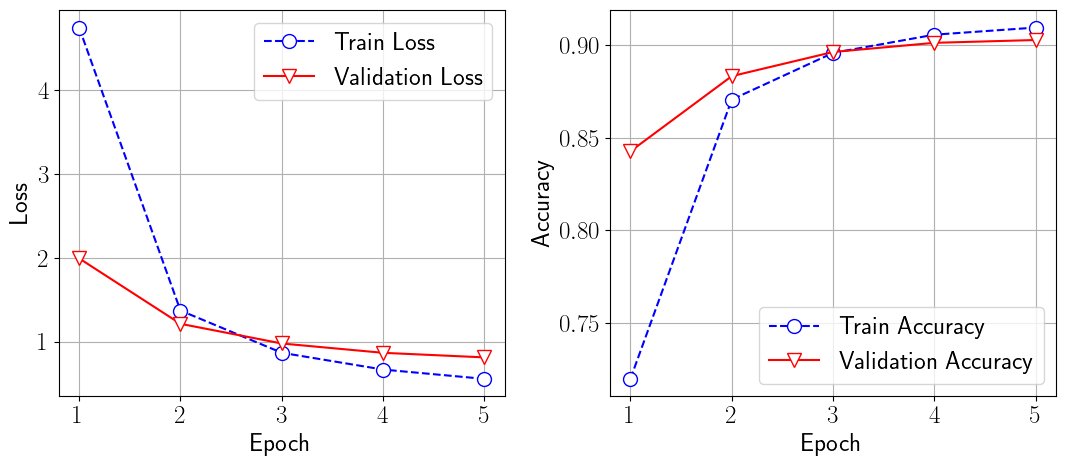

In [255]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
marker = ["o", "v"]
color = ["blue", "red"]
linestyle = ["--", "-"]
markerfacecolor = ["white", "white"]
markersize = 10
grid = True
ax[0].plot(range(1, epochs + 1), train_losses, label="Train Loss", marker=marker[0], color=color[0], linestyle=linestyle[0], markerfacecolor=markerfacecolor[0], markersize=markersize)
ax[0].plot(range(1, epochs + 1), valid_losses, label="Validation Loss", marker=marker[1], color=color[1], linestyle=linestyle[1], markerfacecolor=markerfacecolor[1], markersize=markersize)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(grid)

ax[1].plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy", marker=marker[0], color=color[0], linestyle=linestyle[0], markerfacecolor=markerfacecolor[0], markersize=markersize)
ax[1].plot(range(1, epochs + 1), valid_accuracies, label="Validation Accuracy", marker=marker[1], color=color[1], linestyle=linestyle[1], markerfacecolor=markerfacecolor[1], markersize=markersize)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid(grid)

plt.tight_layout()
plt.show()

In [262]:
def get_word_embedding(model, word, tokenizer, device):
    word_id = torch.tensor(tokenizer.convert_tokens_to_ids(word), dtype=torch.long).to(device)
    word_embedding = model.target_embeddings(word_id)
    return word_embedding

def get_similar_words(model, word, tokenizer, device, top_k=5):
    word_embedding = get_word_embedding(model, word, tokenizer, device)
    context_embeddings = model.context_embeddings.weight
    similarities = torch.cosine_similarity(word_embedding, context_embeddings, dim=1)
    top_similarities, top_indices = torch.topk(similarities, top_k)
    top_words = [tokenizer.convert_ids_to_tokens([idx.item()])[0] for idx in top_indices]
    return top_words, top_similarities